In [1]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.calibration import CalibratedClassifierCV
from pathlib import Path

# Add the correct functions path whether the notebook runs from repo root or /Q1
cwd = Path.cwd()
if (cwd / "functions").exists():
    functions_dir = cwd / "functions"
else:
    functions_dir = cwd / "Q1" / "functions"

sys.path.insert(0, str(functions_dir))

from eval_utils import evaluate_model


# Load the preprocessed datasets
train_df = pd.read_csv('train_df_processed.csv')
test_df = pd.read_csv('test_df_processed.csv')

# Remove any null values that may have been created during I/O
train_df = train_df.dropna(subset=['processed_text'])
test_df = test_df.dropna(subset=['processed_text'])

# Define target labels
y_train = train_df['sentiment_class']
y_test = test_df['sentiment_class']
x_train_raw = train_df['processed_text']

#vectorizer
vectorizer = CountVectorizer()

## Modeling

In [2]:
from tune_pipeline import tune_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer

### MultinomialNB 

In [3]:
param_grid_nb = {
    "vec__ngram_range": [(1, 1), (1, 2)],
    "vec__min_df": [2, 5],
    "vec__max_df": [0.9, 0.95],
    "vec__max_features": [20000, 50000], 
    'model__alpha': [0.01, 0.1, 1.0, 10.0]
}

nb_search = tune_pipeline(vectorizer, MultinomialNB(), param_grid_nb, 
                          x_train_raw, y_train,model_name="Multinomial_NB_BoW" )

GridSearch: 64 combinations, 5 folds => 320 fits
GridSearch: 64 combinations, 5 folds => 320 fits


Multinomial_NB_BoW GridSearch:   0%|          | 0/320 [00:00<?, ?fit/s]

--- Best model saved to: outputs\Multinomial_NB_BoW_best.joblib
--- Performance report saved to: outputs\Multinomial_NB_BoW_tuning_report.csv


#### Results:

Best Params: {'model__alpha': 1.0, 'vec__max_df': 0.9, 'vec__max_features': 20000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}


C:\Users\USER\Documents\ENSTA\4IMO4\LLM-Based-Sentiment-Analysis\Q1\functions\eval_utils.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports//Tuned_MultinomialNB_Full_Report.png


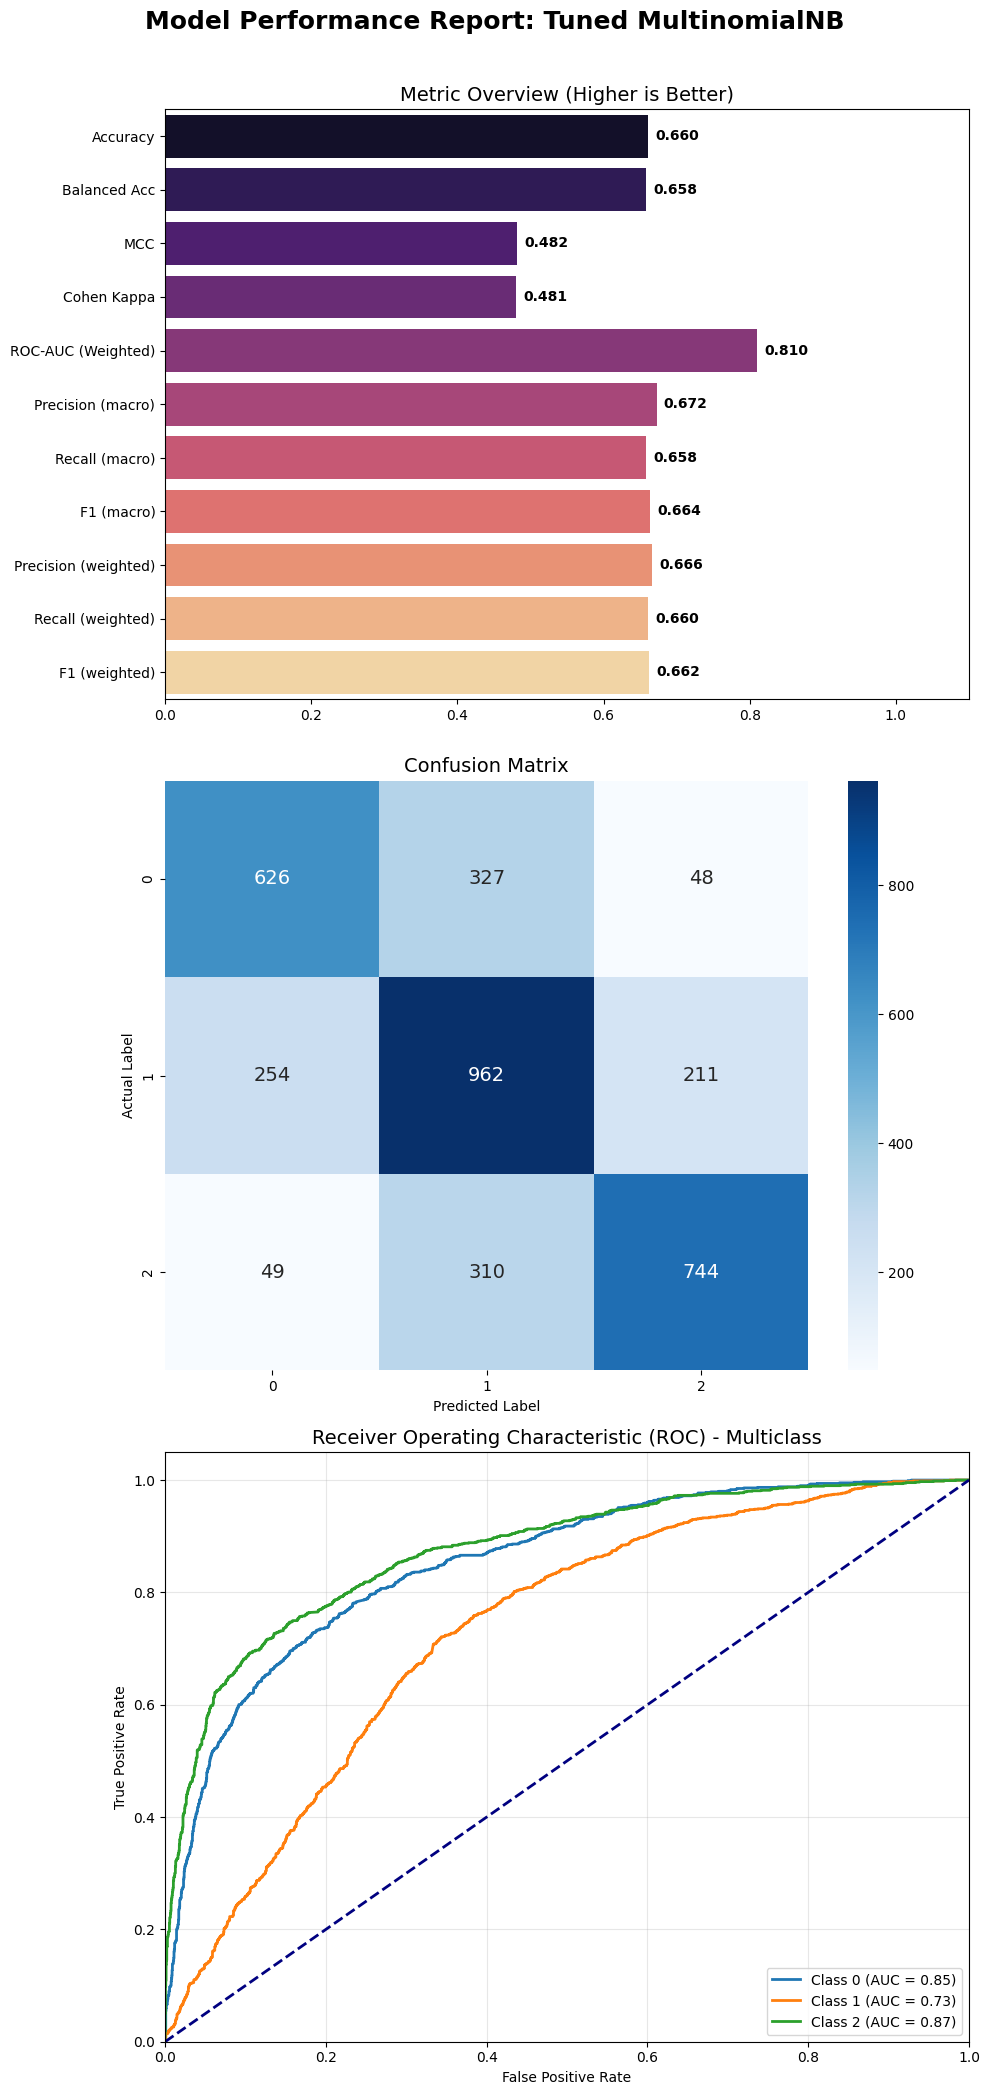

In [4]:
print(f"Best Params: {nb_search.best_params_}")
evaluate_model(y_test, nb_search.predict(test_df['processed_text']),nb_search.predict_proba(test_df['processed_text']), "Tuned MultinomialNB")

### Logistic Regression

In [9]:
param_grid_lr = {
    "vec__ngram_range": [(1, 1), (1, 2)],
    "vec__min_df": [2, 5],
    "vec__max_df": [0.9, 0.95],
    "vec__max_features": [20000, 50000],   # clave para evitar explosión de vocabulario
    "model__C": [0.25, 0.5, 1, 2, 4],
    "model__solver": ["lbfgs"],
    "model__penalty": ["l2"],
    "model__max_iter": [400],
    "model__tol": [1e-3],
}

lr_search = tune_pipeline(vectorizer, LogisticRegression(), 
                          param_grid_lr, x_train_raw, y_train,model_name="Logistic_Reg_BoW")

GridSearch: 80 combinations, 5 folds => 400 fits
GridSearch: 80 combinations, 5 folds => 400 fits


Logistic_Reg_BoW GridSearch:   0%|          | 0/400 [00:00<?, ?fit/s]

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\llm-based-sentiment-analysis-gUrOE1RD-py3.13\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


--- Best model saved to: outputs\Logistic_Reg_BoW_best.joblib
--- Performance report saved to: outputs\Logistic_Reg_BoW_tuning_report.csv


#### Results:

Best Parameters: {'model__C': 0.25, 'model__max_iter': 400, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'model__tol': 0.001, 'vec__max_df': 0.9, 'vec__max_features': 20000, 'vec__min_df': 2, 'vec__ngram_range': (1, 1)}


C:\Users\USER\Documents\ENSTA\4IMO4\LLM-Based-Sentiment-Analysis\Q1\functions\eval_utils.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports//WoB_Logistic_Regression_tuned_Full_Report.png


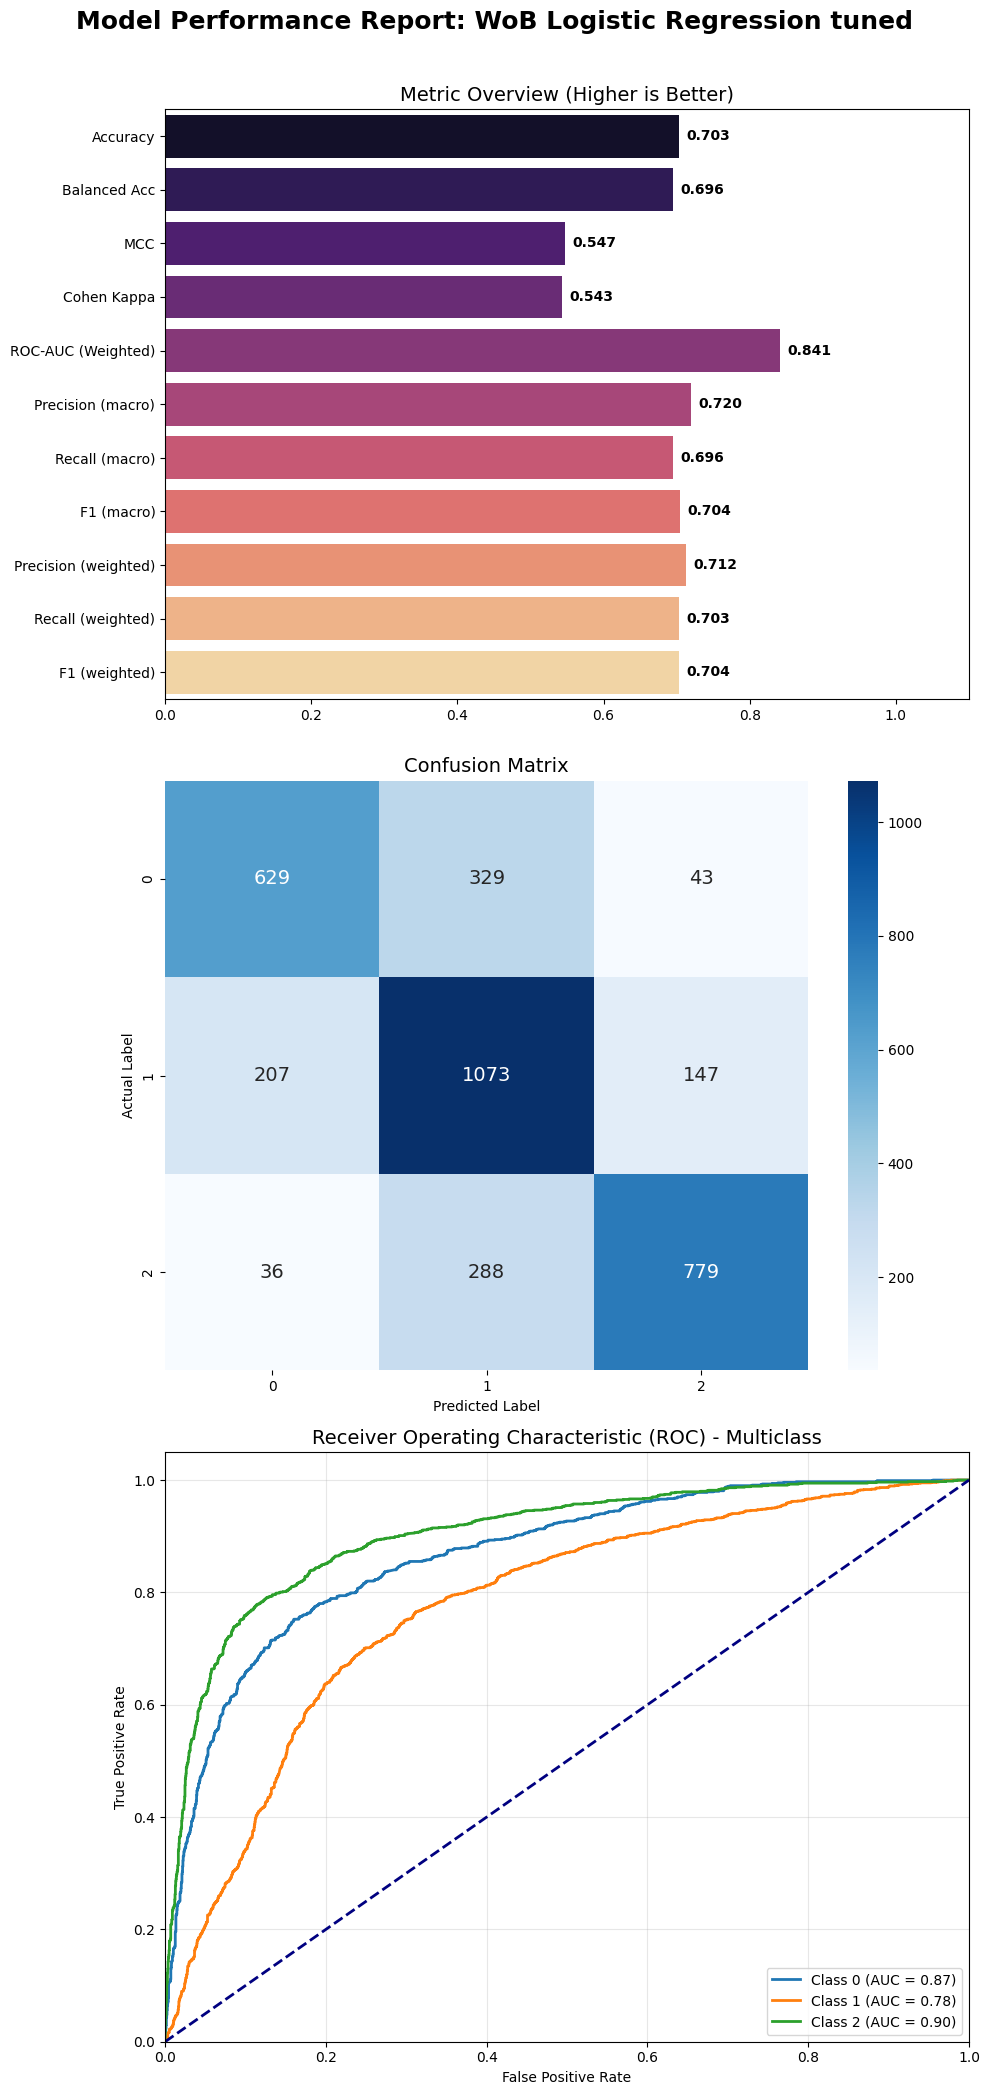

In [10]:
print(f"Best Parameters: {lr_search.best_params_}")

evaluate_model(
    y_test,
    lr_search.predict(test_df['processed_text']),
    lr_search.predict_proba(test_df['processed_text']),
    "WoB Logistic Regression tuned"
)

### Linear SVM

In [16]:
param_grid_svm = {
    "vec__ngram_range": [(1, 1), (1, 2)],
    "vec__min_df": [2, 5],
    "vec__max_df": [0.9, 0.95],
    "vec__max_features": [20000, 50000],
    "model__estimator__C": [0.1, 1, 10],
    "model__estimator__loss": ["squared_hinge"],
    "model__estimator__max_iter": [2000],
}

svm = LinearSVC()
calibrated = CalibratedClassifierCV(estimator=svm, method="sigmoid", cv=5)

svm_search = tune_pipeline(
    vectorizer,
    calibrated,
    param_grid_svm,
    x_train_raw,
    y_train,
    model_name="SVM_Reg_BoW"
)


GridSearch: 48 combinations, 5 folds => 240 fits
GridSearch: 48 combinations, 5 folds => 240 fits


SVM_Reg_BoW GridSearch:   0%|          | 0/240 [00:00<?, ?fit/s]

--- Best model saved to: outputs\SVM_Reg_BoW_best.joblib
--- Performance report saved to: outputs\SVM_Reg_BoW_tuning_report.csv


#### Results:

Best Parameters: {'model__estimator__C': 0.1, 'model__estimator__loss': 'squared_hinge', 'model__estimator__max_iter': 2000, 'vec__max_df': 0.9, 'vec__max_features': 50000, 'vec__min_df': 2, 'vec__ngram_range': (1, 2)}


C:\Users\USER\Documents\ENSTA\4IMO4\LLM-Based-Sentiment-Analysis\Q1\functions\eval_utils.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports//WoB_SVM_tuned_Full_Report.png


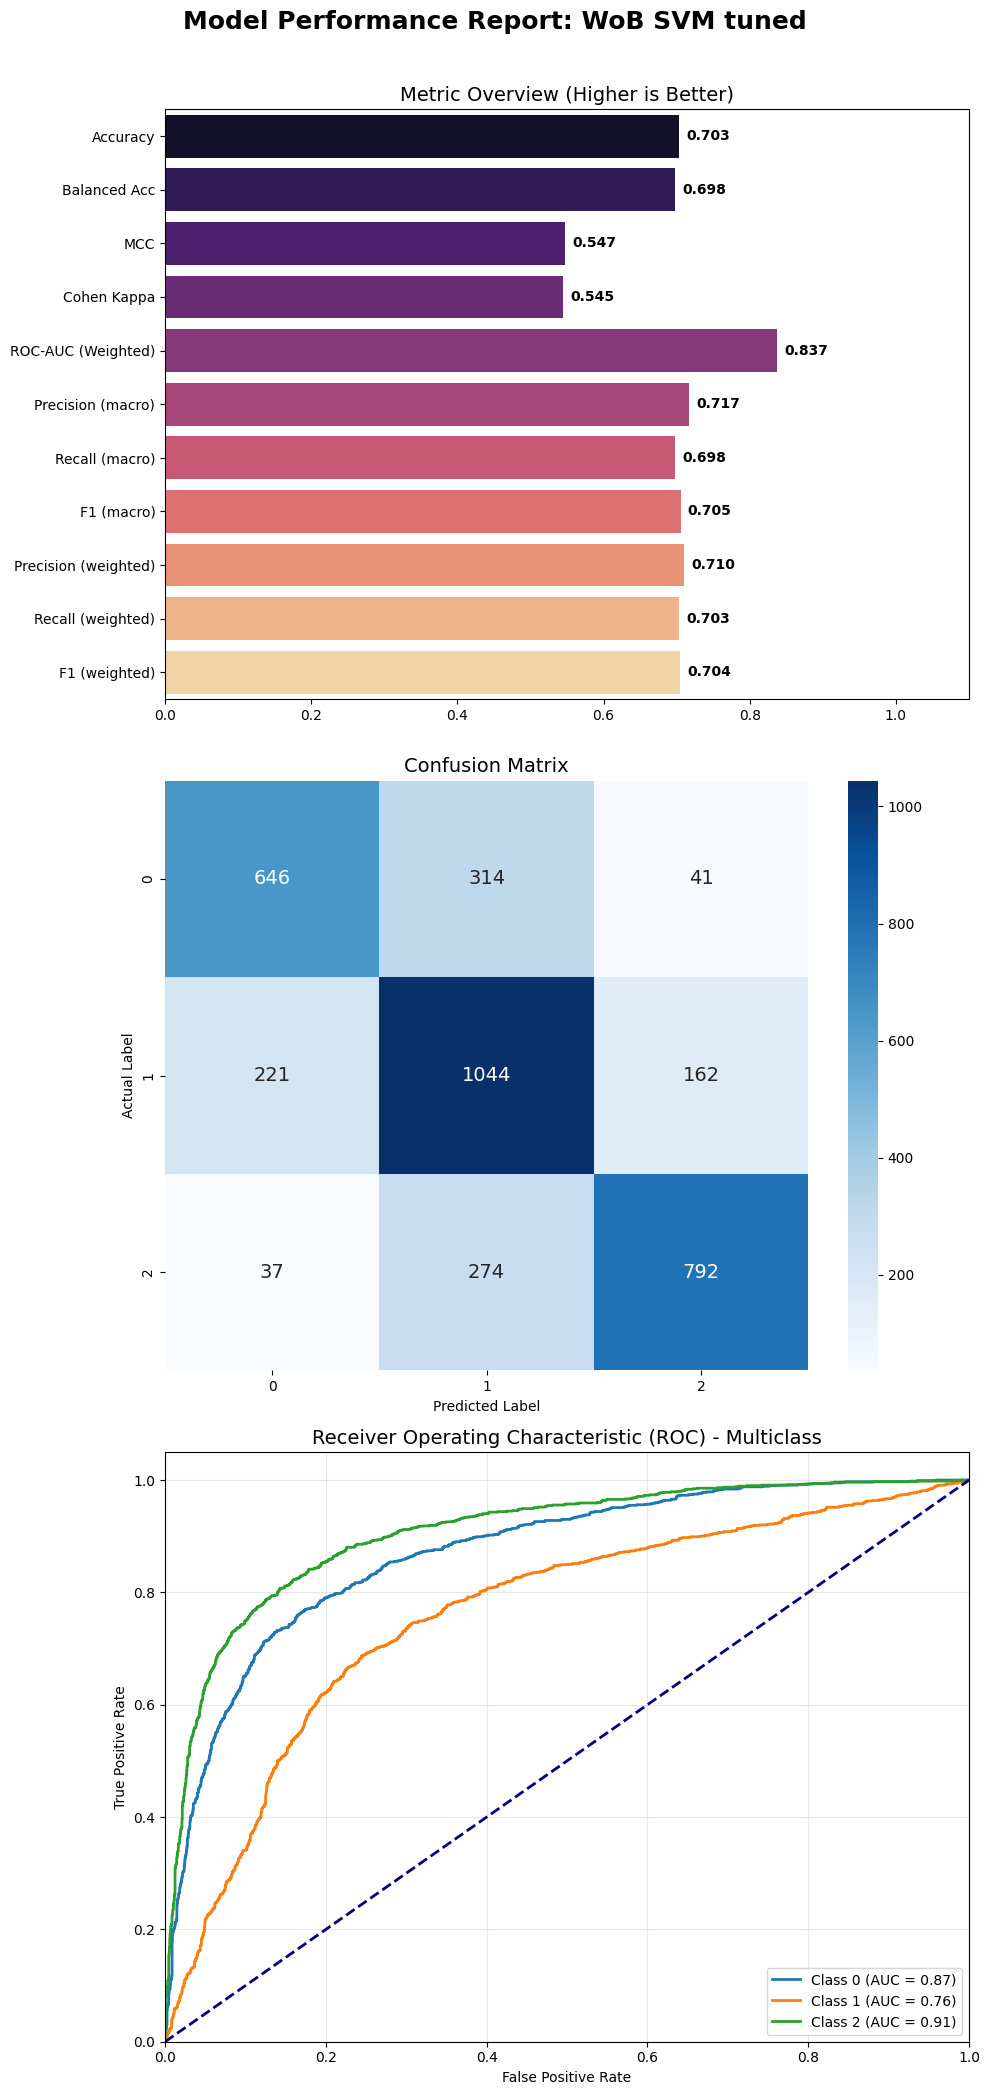

In [17]:
print(f"Best Parameters: {svm_search.best_params_}")
evaluate_model(
    y_test,
    svm_search.predict(test_df['processed_text']),
    svm_search.predict_proba(test_df['processed_text']),
    "WoB SVM tuned"
)

### Random Forest / Bagging / Gradient Boosting

In [3]:
param_grid_rf = {
    "vec__ngram_range": [(1, 1), (1, 2)],
    "vec__min_df": [2, 5],
    "vec__max_df": [0.9, 0.95],
    "vec__max_features": [20000, 50000],
    "model__n_estimators": [100, 120],
    "model__max_depth": [None, 20],
    "model__min_samples_split": [2, 5],
    "model__class_weight": ["balanced", None],
}

rf_search = tune_pipeline(vectorizer, RandomForestClassifier(n_jobs=-1), 
                          param_grid_rf, x_train_raw, y_train,model_name="Random_Forest_BoW")

GridSearch: 256 combinations, 5 folds => 1280 fits
GridSearch: 256 combinations, 5 folds => 1280 fits


Random_Forest_BoW GridSearch:   0%|          | 0/1280 [00:00<?, ?fit/s]

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\llm-based-sentiment-analysis-gUrOE1RD-py3.13\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


--- Best model saved to: outputs\Random_Forest_BoW_best.joblib
--- Performance report saved to: outputs\Random_Forest_BoW_tuning_report.csv


#### Results:

Best Parameters: {'model__class_weight': None, 'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 120, 'vec__max_df': 0.95, 'vec__max_features': 50000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}


C:\Users\USER\Documents\ENSTA\4IMO4\LLM-Based-Sentiment-Analysis\Q1\functions\eval_utils.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports//WoB_Random_Forest_tuned_Full_Report.png


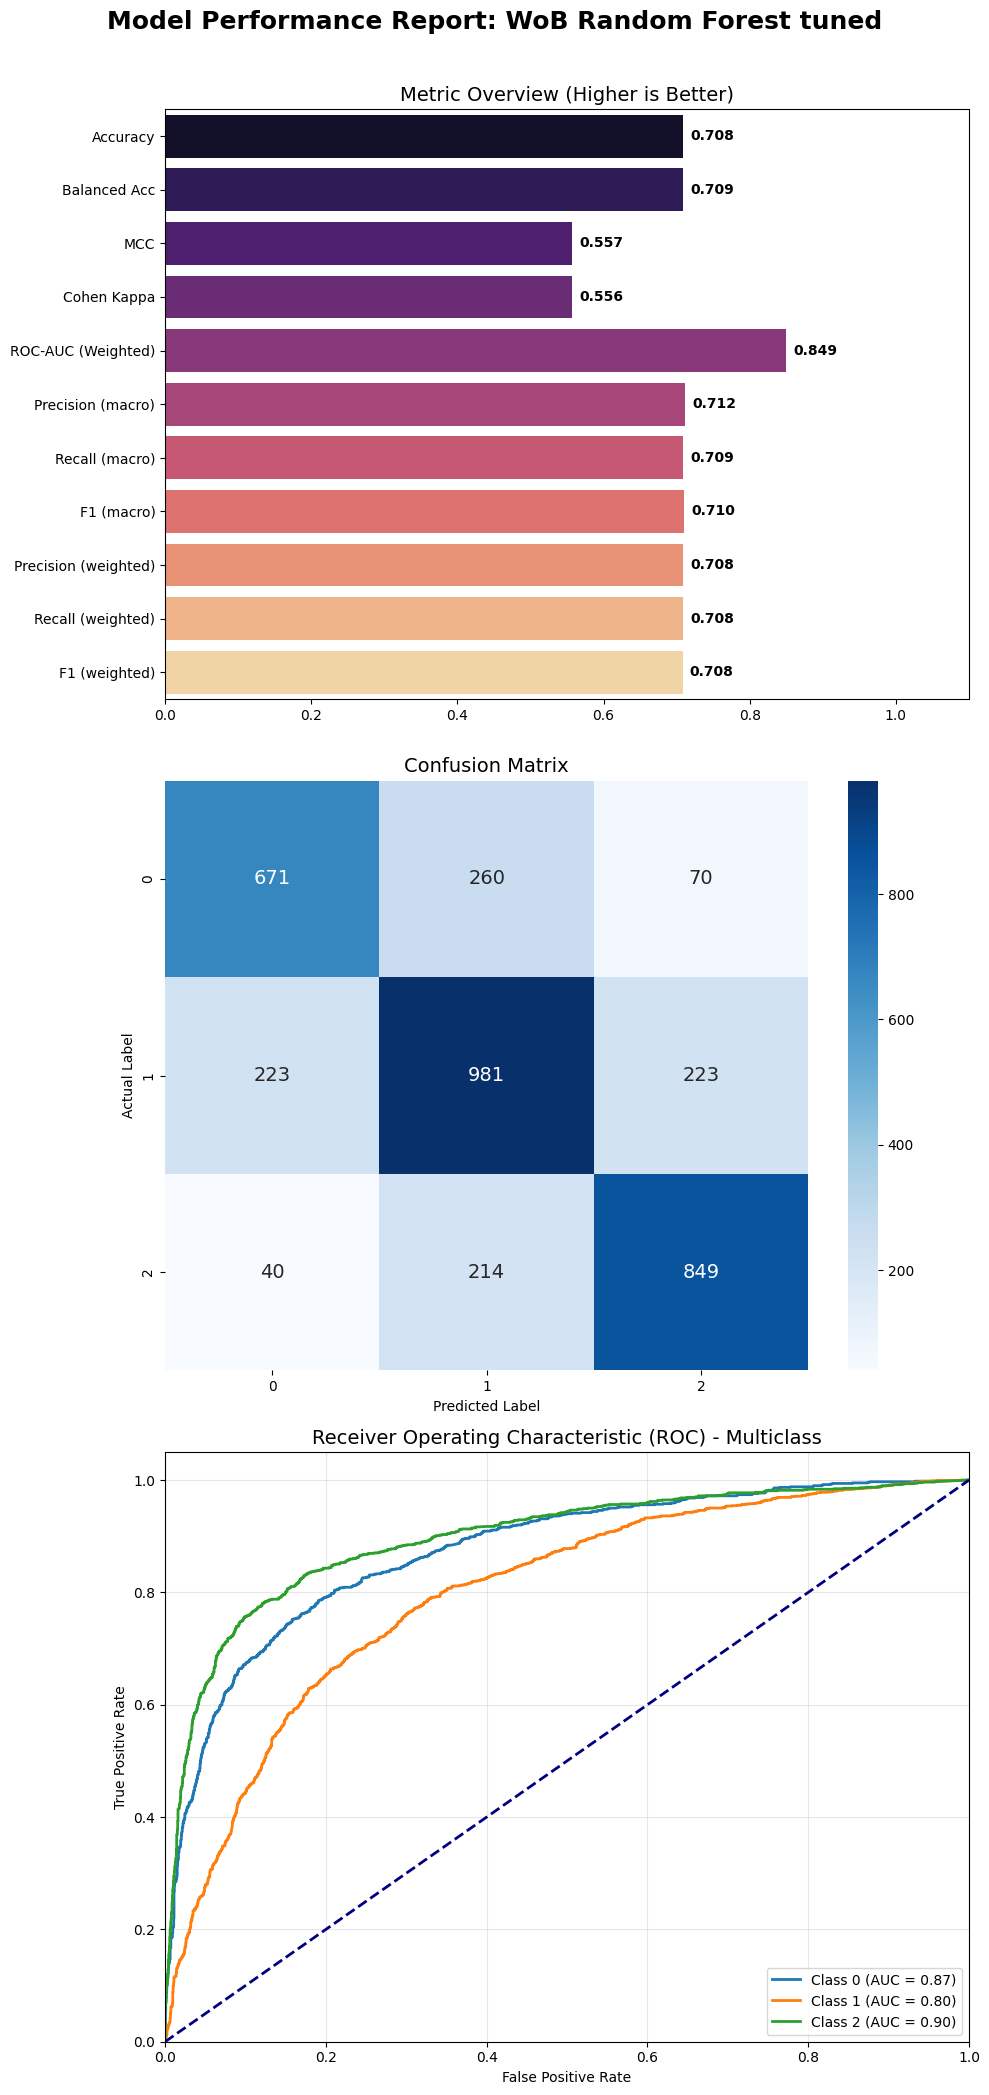

In [4]:
print(f"Best Parameters: {rf_search.best_params_}")
evaluate_model(
    y_test,
    rf_search.predict(test_df['processed_text']),
    rf_search.predict_proba(test_df['processed_text']),
    "WoB Random Forest tuned"
)